# Лабораторна робота 14,15

1. Опрацюйте код застосування автоенкодера на прикладі даних з електрокаріограми
2. Здійсніть навчання та дослідження якості автоенкодера на основі даних про шахрайство із кредитними картками

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Налаштування графіки
mpl.rcParams['figure.figsize'] = (10, 5)
mpl.rcParams['axes.grid'] = False

In [3]:
df_TRAIN = pd.read_csv("ECG5000_TRAIN.txt", sep='  ', header=None, engine='python')
df_TEST = pd.read_csv("ECG5000_TEST.txt", sep='  ', header=None, engine='python')
df = pd.concat([df_TRAIN, df_TEST])

df.columns = ['label'] + [f'f{i}' for i in range(1, df.shape[1])]
df

,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140
0,1.0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,...,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137
1,1.0,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,...,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250
2,1.0,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,...,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797
3,1.0,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,...,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564
4,1.0,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,...,0.966606,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,4.0,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,...,0.205543,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334
4496,2.0,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,...,1.218185,1.258419,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932
4497,2.0,-1.351779,-2.209006,-2.520225,-3.061475,-3.065141,-3.030739,-2.622720,-2.044092,-1.295874,...,-0.896575,-1.512234,-2.076075,-2.586042,-3.322799,-3.627311,-3.437038,-2.260023,-1.577823,-0.684531
4498,2.0,-1.124432,-1.905039,-2.192707,-2.904320,-2.900722,-2.761252,-2.569705,-2.043893,-1.490538,...,-2.495989,-2.821782,-3.268355,-3.634981,-3.168765,-2.245878,-1.262260,-0.443307,-0.559769,0.108568


In [4]:
normal_data = df[df['label'] == 1]
anomaly_data = df[df['label'] != 1]

# Відокремлення ознак
X_normal = normal_data.drop('label', axis=1).values
X_anomaly = anomaly_data.drop('label', axis=1).values

# Масштабування
scaler = MinMaxScaler()
X_normal_scaled = scaler.fit_transform(X_normal)
X_anomaly_scaled = scaler.transform(X_anomaly)

# Розділення нормальних даних на train/test
X_train, X_test_normal = train_test_split(X_normal_scaled, test_size=0.2, random_state=42)

In [5]:
# Створення автоенкодера
input_dim = X_train.shape[1]
encoding_dim = 64

input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation="relu")(input_layer)
encoded = Dense(encoding_dim, activation="relu")(encoded)
decoded = Dense(128, activation="relu")(encoded)
decoded = Dense(input_dim, activation="sigmoid")(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mae')

# Навчання
history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(X_test_normal, X_test_normal)
)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1106 - val_loss: 0.0737
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0691 - val_loss: 0.0624
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0590 - val_loss: 0.0541
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0519 - val_loss: 0.0467
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0454 - val_loss: 0.0420
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0416 - val_loss: 0.0392
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0388 - val_loss: 0.0376
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0370 - val_loss: 0.0359
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0357 - val_loss: 0.0340
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0333 - val_loss: 0.0325
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0322 - val_loss: 0.0313
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

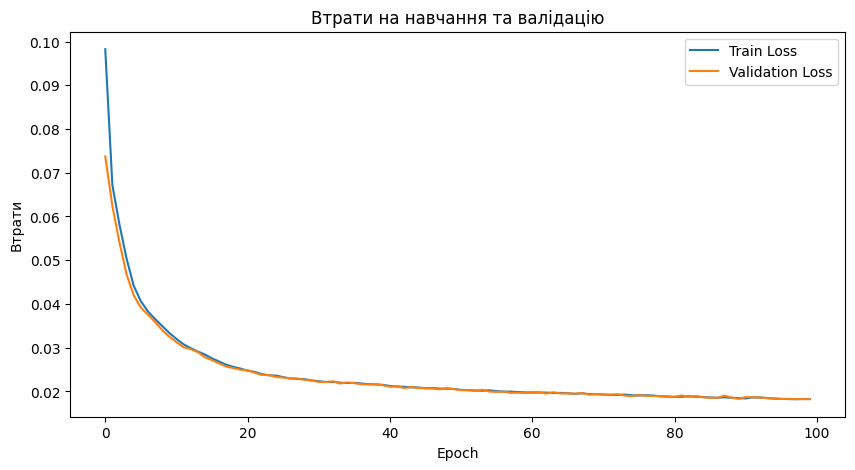

In [6]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Втрати на навчання та валідацію')
plt.xlabel('Epoch')
plt.ylabel('Втрати')
plt.show()

In [7]:
# Тестування на нормальних та аномальних даних
reconstructed_normal = autoencoder.predict(X_test_normal)
reconstructed_anomaly = autoencoder.predict(X_anomaly_scaled)

# Розрахунок похибок
mse_normal = np.mean(np.abs(reconstructed_normal - X_test_normal), axis=1)
mse_anomaly = np.mean(np.abs(reconstructed_anomaly - X_anomaly_scaled), axis=1)

# Знаходження порогу
threshold = np.mean(mse_normal) + 3*np.std(mse_normal)
print(f"Threshold for anomaly detection: {threshold}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Threshold for anomaly detection: 0.04373202403273349


In [12]:
# Класифікація
preds_normal = (mse_normal > threshold).astype(int)
preds_anomaly = (mse_anomaly > threshold).astype(int)

# Об'єднання
y_true = np.concatenate([np.zeros_like(preds_normal), np.ones_like(preds_anomaly)])
y_pred = np.concatenate([preds_normal, preds_anomaly])

print("confusion_matrix:\n", confusion_matrix(y_true, y_pred), "\n\n")
print("classification_report:\n", classification_report(y_true, y_pred))

confusion_matrix:
 [[ 571   13]
 [ 248 1833]] 


classification_report:
               precision    recall  f1-score   support

           0       0.70      0.98      0.81       584
           1       0.99      0.88      0.93      2081

    accuracy                           0.90      2665
   macro avg       0.85      0.93      0.87      2665
weighted avg       0.93      0.90      0.91      2665



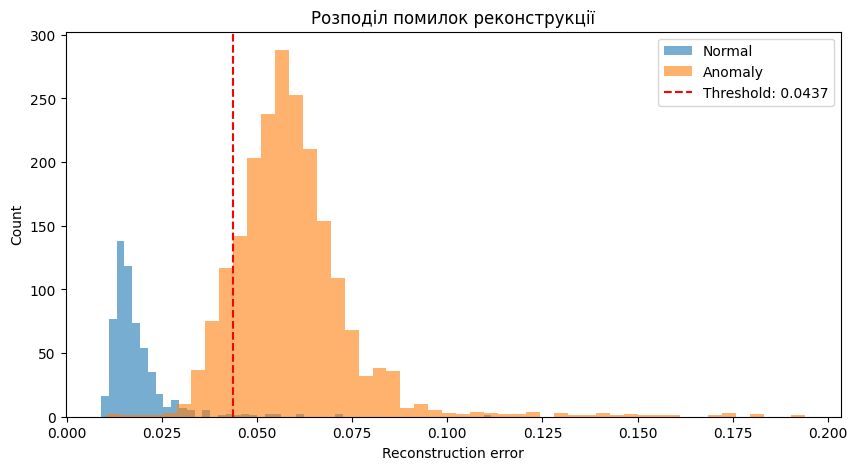

In [9]:
# Гістограма
plt.hist(mse_normal, bins=50, alpha=0.6, label="Normal")
plt.hist(mse_anomaly, bins=50, alpha=0.6, label="Anomaly")
plt.axvline(threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.legend()
plt.title("Розподіл помилок реконструкції")
plt.xlabel("Reconstruction error")
plt.ylabel("Count")
plt.show()